### Import necessary packages

In [1]:
import tensorflow as tf
import librosa
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import wave
import os

ROOT_DIR = r"C:\Users\d.sani\MIDAS\task1\tensorflow-speech-recognition-challenge"
labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]

In [2]:
x = None
y = None

audio_train_file_path = os.path.join(ROOT_DIR, "train", "audio")
all_labels = os.listdir(audio_train_file_path)

Count the average number of samples with known and unknown labels in order to create balanced samples of unknown labels

In [3]:
unknown = 0
known = 0
u = 0
k = 0
for label in all_labels:
    path = os.path.join(audio_train_file_path, label)
    all_files = [os.path.join(path, fname) for fname in os.listdir(path)]
    if label in labels:
        known += len(all_files)
        k += 1
    elif label != "_background_noise_":
        unknown += len(all_files)
        u += 1
print("Known:", known//k)
print("Unknown:", unknown//u)

Known: 2368
Unknown: 2051


<strong><i>limit</i></strong> refers to the maximum number of samples to be taken from a label that is to be considered as unknown during evaluation

In [4]:
limit = known//(k*u)

### Create dataset

Dataset of known and unknown labels

In [5]:
for label in all_labels:
    path = os.path.join(audio_train_file_path, label)
    all_files = [os.path.join(path, fname) for fname in os.listdir(path)]
    if label == "_background_noise_":
        continue
    print(label)
    if label not in labels:
        label = "unknown"
    i = 0
    for file in all_files:
        audio, sr = librosa.load(file) # sr refers to the sampling rate
        audio = audio[:20000:sr//100] # Get every sr/100 samples from first 20000 samples only
        audio = np.pad(audio, (0, 100 - audio.shape[0]), mode="constant", constant_values=0)
        if x is None:
            x = np.asarray([audio])
            y = np.asarray([labels.index(label)])
        else:
            x = np.vstack([x, audio])
            y = np.vstack([y, labels.index(label)])
        i += 1
        if label == "unknown" and i == limit: # i checks the number of samples taken from the current label. For unknown labels, if i > limit then break and continue with next label
            break

bed
bird
cat
dog
down
eight
five
four
go
happy
house
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
wow
yes
zero


In [6]:
x.shape, y.shape

((26042, 100), (26042, 1))

Dataset of silence label
Audio files for this label is very less, but the length of audio is greater than one second. Hence, one audio is broken into audio samples of 1 sec each. Here, <strong><i>limit</i></strong> refers to the maximum number of audio samples of 1sec each that are to be taken from one audio file

In [7]:
path = os.path.join(audio_train_file_path, "_background_noise_")
all_files = [os.path.join(path, fname) for fname in os.listdir(path) if ".wav" in fname]
limit = known//(k*len(all_files))

In [8]:
for file in all_files:
    audio, sr = librosa.load(file)
    j = 0
    for i in range(0, len(audio), 20000):
        a = np.pad(audio[i:i+20000:sr//100], (0, 100 - audio[i:i+20000:sr//100].shape[0]), mode="constant", constant_values=0)
        x = np.vstack([x, a])
        y = np.vstack([y, labels.index("silence")])
        j += 1
        if j == limit:
            break

In [9]:
x.shape, y.shape

((26486, 100), (26486, 1))

### Train-Test Split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

### Model Creation & Training

In [13]:
def Model(X, dropout=0.4):
    _input = tf.keras.layers.Input(X)
    x = tf.keras.layers.Dense(512)(_input)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(len(labels))(x)
    x = tf.keras.layers.Activation(tf.nn.softmax)(x)
    return tf.keras.Model(_input, x)

model = Model(x[0].shape)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
checkpoint_filepath = "weights/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
H = model.fit(x_train, y_train, batch_size=256, epochs=500, validation_split=0.25, shuffle=True, callbacks=[model_checkpoint_callback])

Train on 14898 samples, validate on 4966 samples
Epoch 1/500
14898/14898 [==============================] - 4s 286us/sample - loss: 3.0879 - accuracy: 0.0918 - val_loss: 2.4673 - val_accuracy: 0.0868
Epoch 2/500
14898/14898 [==============================] - 1s 76us/sample - loss: 2.7952 - accuracy: 0.0924 - val_loss: 2.4604 - val_accuracy: 0.0944
Epoch 3/500
14898/14898 [==============================] - 1s 66us/sample - loss: 2.6687 - accuracy: 0.0965 - val_loss: 2.4563 - val_accuracy: 0.0932
Epoch 4/500
14898/14898 [==============================] - 2s 120us/sample - loss: 2.6150 - accuracy: 0.0954 - val_loss: 2.4548 - val_accuracy: 0.0872
Epoch 5/500
14898/14898 [==============================] - 1s 73us/sample - loss: 2.5655 - accuracy: 0.0963 - val_loss: 2.4495 - val_accuracy: 0.0884
Epoch 6/500
14898/14898 [==============================] - 1s 57us/sample - loss: 2.5434 - accuracy: 0.0953 - val_loss: 2.4508 - val_accuracy: 0.0866
Epoch 7/500
14898/14898 [========================

Epoch 55/500
14898/14898 [==============================] - 1s 60us/sample - loss: 2.2651 - accuracy: 0.1949 - val_loss: 2.4994 - val_accuracy: 0.1023
Epoch 56/500
14898/14898 [==============================] - 1s 55us/sample - loss: 2.2603 - accuracy: 0.1941 - val_loss: 2.5022 - val_accuracy: 0.1067
Epoch 57/500
14898/14898 [==============================] - 1s 64us/sample - loss: 2.2639 - accuracy: 0.1932 - val_loss: 2.5056 - val_accuracy: 0.1051
Epoch 58/500
14898/14898 [==============================] - 2s 113us/sample - loss: 2.2613 - accuracy: 0.1921 - val_loss: 2.5045 - val_accuracy: 0.1047
Epoch 59/500
14898/14898 [==============================] - 1s 49us/sample - loss: 2.2510 - accuracy: 0.1970 - val_loss: 2.5072 - val_accuracy: 0.1045
Epoch 60/500
14898/14898 [==============================] - 1s 49us/sample - loss: 2.2519 - accuracy: 0.2032 - val_loss: 2.5080 - val_accuracy: 0.1061
Epoch 61/500
14898/14898 [==============================] - 1s 64us/sample - loss: 2.2521 - a

Epoch 163/500
14898/14898 [==============================] - 1s 50us/sample - loss: 2.0987 - accuracy: 0.2684 - val_loss: 2.5443 - val_accuracy: 0.1122
Epoch 164/500
14898/14898 [==============================] - 1s 62us/sample - loss: 2.1070 - accuracy: 0.2639 - val_loss: 2.5437 - val_accuracy: 0.1083
Epoch 165/500
14898/14898 [==============================] - 2s 115us/sample - loss: 2.0973 - accuracy: 0.2661 - val_loss: 2.5437 - val_accuracy: 0.1108
Epoch 166/500
14898/14898 [==============================] - 1s 54us/sample - loss: 2.1038 - accuracy: 0.2656 - val_loss: 2.5420 - val_accuracy: 0.1104
Epoch 167/500
14898/14898 [==============================] - 1s 50us/sample - loss: 2.1050 - accuracy: 0.2618 - val_loss: 2.5372 - val_accuracy: 0.1101
Epoch 168/500
14898/14898 [==============================] - 1s 66us/sample - loss: 2.1068 - accuracy: 0.2633 - val_loss: 2.5367 - val_accuracy: 0.1081
Epoch 169/500
14898/14898 [==============================] - 2s 113us/sample - loss: 2.

Epoch 270/500
14898/14898 [==============================] - 1s 51us/sample - loss: 2.0387 - accuracy: 0.2955 - val_loss: 2.5436 - val_accuracy: 0.1118
Epoch 271/500
14898/14898 [==============================] - 1s 68us/sample - loss: 2.0458 - accuracy: 0.2937 - val_loss: 2.5456 - val_accuracy: 0.1134
Epoch 272/500
14898/14898 [==============================] - 2s 113us/sample - loss: 2.0436 - accuracy: 0.2878 - val_loss: 2.5446 - val_accuracy: 0.1138
Epoch 273/500
14898/14898 [==============================] - 1s 50us/sample - loss: 2.0521 - accuracy: 0.2920 - val_loss: 2.5394 - val_accuracy: 0.1112
Epoch 274/500
14898/14898 [==============================] - 1s 54us/sample - loss: 2.0485 - accuracy: 0.2902 - val_loss: 2.5465 - val_accuracy: 0.1128
Epoch 275/500
14898/14898 [==============================] - 1s 86us/sample - loss: 2.0431 - accuracy: 0.2880 - val_loss: 2.5449 - val_accuracy: 0.1134
Epoch 276/500
14898/14898 [==============================] - 1s 95us/sample - loss: 2.0

Epoch 324/500
14898/14898 [==============================] - 1s 54us/sample - loss: 2.0238 - accuracy: 0.2990 - val_loss: 2.5469 - val_accuracy: 0.1132
Epoch 325/500
14898/14898 [==============================] - 2s 110us/sample - loss: 2.0141 - accuracy: 0.2993 - val_loss: 2.5557 - val_accuracy: 0.1136
Epoch 326/500
14898/14898 [==============================] - 1s 62us/sample - loss: 2.0173 - accuracy: 0.3037 - val_loss: 2.5520 - val_accuracy: 0.1168
Epoch 327/500
14898/14898 [==============================] - 1s 50us/sample - loss: 2.0287 - accuracy: 0.2986 - val_loss: 2.5516 - val_accuracy: 0.1150
Epoch 328/500
14898/14898 [==============================] - 1s 54us/sample - loss: 2.0262 - accuracy: 0.2981 - val_loss: 2.5507 - val_accuracy: 0.1130
Epoch 329/500
14898/14898 [==============================] - 2s 115us/sample - loss: 2.0237 - accuracy: 0.3096 - val_loss: 2.5429 - val_accuracy: 0.1148
Epoch 330/500
14898/14898 [==============================] - 1s 59us/sample - loss: 2.

Epoch 378/500
14898/14898 [==============================] - 2s 110us/sample - loss: 2.0156 - accuracy: 0.3051 - val_loss: 2.5496 - val_accuracy: 0.1122
Epoch 379/500
14898/14898 [==============================] - 1s 67us/sample - loss: 2.0022 - accuracy: 0.3119 - val_loss: 2.5453 - val_accuracy: 0.1130
Epoch 380/500
14898/14898 [==============================] - 1s 51us/sample - loss: 2.0078 - accuracy: 0.3083 - val_loss: 2.5496 - val_accuracy: 0.1101
Epoch 381/500
14898/14898 [==============================] - 1s 51us/sample - loss: 2.0042 - accuracy: 0.3065 - val_loss: 2.5490 - val_accuracy: 0.1158
Epoch 382/500
14898/14898 [==============================] - 2s 112us/sample - loss: 2.0071 - accuracy: 0.3038 - val_loss: 2.5537 - val_accuracy: 0.1101
Epoch 383/500
14898/14898 [==============================] - 1s 64us/sample - loss: 2.0053 - accuracy: 0.3056 - val_loss: 2.5525 - val_accuracy: 0.1106
Epoch 384/500
14898/14898 [==============================] - 1s 51us/sample - loss: 2.

Epoch 432/500
14898/14898 [==============================] - 2s 144us/sample - loss: 1.9928 - accuracy: 0.3122 - val_loss: 2.5546 - val_accuracy: 0.1152
Epoch 433/500
14898/14898 [==============================] - 3s 196us/sample - loss: 1.9853 - accuracy: 0.3141 - val_loss: 2.5585 - val_accuracy: 0.1136
Epoch 434/500
14898/14898 [==============================] - 1s 96us/sample - loss: 1.9808 - accuracy: 0.3150 - val_loss: 2.5541 - val_accuracy: 0.1138
Epoch 435/500
14898/14898 [==============================] - 1s 54us/sample - loss: 2.0049 - accuracy: 0.3078 - val_loss: 2.5525 - val_accuracy: 0.1170
Epoch 436/500
14898/14898 [==============================] - 1s 67us/sample - loss: 1.9945 - accuracy: 0.3135 - val_loss: 2.5556 - val_accuracy: 0.1160
Epoch 437/500
14898/14898 [==============================] - 2s 135us/sample - loss: 1.9926 - accuracy: 0.3135 - val_loss: 2.5538 - val_accuracy: 0.1150
Epoch 438/500
14898/14898 [==============================] - 2s 150us/sample - loss: 

Epoch 486/500
14898/14898 [==============================] - 1s 52us/sample - loss: 1.9839 - accuracy: 0.3180 - val_loss: 2.5514 - val_accuracy: 0.1130
Epoch 487/500
14898/14898 [==============================] - 1s 86us/sample - loss: 1.9934 - accuracy: 0.3103 - val_loss: 2.5499 - val_accuracy: 0.1114
Epoch 488/500
14898/14898 [==============================] - 2s 144us/sample - loss: 1.9862 - accuracy: 0.3127 - val_loss: 2.5541 - val_accuracy: 0.1122
Epoch 489/500
14898/14898 [==============================] - 1s 94us/sample - loss: 1.9845 - accuracy: 0.3163 - val_loss: 2.5520 - val_accuracy: 0.1144
Epoch 490/500
14898/14898 [==============================] - 1s 51us/sample - loss: 1.9935 - accuracy: 0.3137 - val_loss: 2.5532 - val_accuracy: 0.1144
Epoch 491/500
14898/14898 [==============================] - 1s 51us/sample - loss: 1.9829 - accuracy: 0.3175 - val_loss: 2.5498 - val_accuracy: 0.1138
Epoch 492/500
14898/14898 [==============================] - 2s 102us/sample - loss: 1.

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

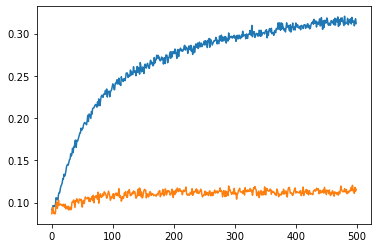

In [14]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])